# Install and Import Dependencies


In [1]:
pip install opencv-python numpy matplotlib mediapipe tensorflow scikit-learn tqdm fasttext-wheel

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import gc
import os
from matplotlib import pyplot as plt
import shutil
import threading
import mediapipe as mp
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import fasttext
import fasttext.util

# Load dataset


In [4]:
# defining a base directory to the dataset folder
main_path = './dataset/'
# opening the json file for read
with open(main_path + 'WLASL_v0.3.json', 'r') as json_file:
    data = json.load(json_file)

In [5]:
# checking to see if data has loaded properly
len(data[0]['instances'])

40

# Create Labels and Features


In [6]:
# Open the file in read mode
with open(main_path + 'missing.txt', 'r') as file:
    # Read all lines from the file and store them in a list
    missing_video_ids = [line.strip() for line in file.readlines()]

# Now, 'lines' contains an array of strings, where each element is a line from the file
print(missing_video_ids)

[]


In [7]:
del file, json_file
gc.collect()

0

In [8]:
gloss_list = []
video_name_list = []
start_frame = []
end_frame = []
category_list = []
vid_dir = main_path + '/videos'
progress = 0
data_count = 0

# looping through each word / gesture
for word in data:
    # get the all instances of each word for easy testing of code
    for i in range(len(word['instances'])):

        # if video is missing, skip it
        if any(word["instances"][i]["video_id"] in line for line in missing_video_ids):
            continue

        # get the video path
        vid_name = os.path.join(
            vid_dir, f'{word["instances"][i]["video_id"]}.mp4')

        # get the start, end and the label
        start = word['instances'][i]['frame_start']
        end = word['instances'][i]['frame_end']
        label = word['gloss']
        category = word['instances'][i]['split']

        # adding to the list
        video_name_list.append(vid_name)
        gloss_list.append(label)
        start_frame.append(start)
        end_frame.append(end)
        category_list.append(category)

        # updating progress after each loop
        progress += 1
        data_count += 1

print(data_count)

21083


In [9]:
unique_words_count = len(set(gloss_list))
print(
    f'number of unique words = {unique_words_count}\nnumber of videos = {len(video_name_list)}')
print(video_name_list)

number of unique words = 2000
number of videos = 21083
['./dataset//videos\\69241.mp4', './dataset//videos\\65225.mp4', './dataset//videos\\68011.mp4', './dataset//videos\\68208.mp4', './dataset//videos\\68012.mp4', './dataset//videos\\70212.mp4', './dataset//videos\\70266.mp4', './dataset//videos\\07085.mp4', './dataset//videos\\07086.mp4', './dataset//videos\\07087.mp4', './dataset//videos\\07069.mp4', './dataset//videos\\07088.mp4', './dataset//videos\\07089.mp4', './dataset//videos\\07090.mp4', './dataset//videos\\07091.mp4', './dataset//videos\\07092.mp4', './dataset//videos\\07093.mp4', './dataset//videos\\07068.mp4', './dataset//videos\\07094.mp4', './dataset//videos\\07095.mp4', './dataset//videos\\07096.mp4', './dataset//videos\\07097.mp4', './dataset//videos\\07070.mp4', './dataset//videos\\07098.mp4', './dataset//videos\\07099.mp4', './dataset//videos\\07071.mp4', './dataset//videos\\07072.mp4', './dataset//videos\\07073.mp4', './dataset//videos\\67424.mp4', './dataset//vide

In [10]:
del data, unique_words_count, video_name_list, word, progress
gc.collect()

0

# Collect Keypoint Values From Videos


### Mediapipe Implementation


In [11]:
# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils


def mediapipe_detection(image, model):
    if image is None:
        raise ValueError(f"Failed to load image: {image}")
    # COLOR CONVERSION BGR 2 RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Image is no longer writeable to improve performance
    image.flags.writeable = False
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return image, results

### Centering The Landmarks


In [12]:
def adjust_3d_landmarks(arr, center):
    # the array reshaped to have shape (n*m, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # the center array repeated to have shape (n*m, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # the center array subtracted from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # arr_adjusted reshaped back to shape (n, m, 3)
    arr_adjusted = arr_adjusted.reshape(arr.shape)

    return arr_adjusted

### Extracting Keypoints From A Frame


### Landmarks

- **Hands:** 42 (21 on each hand)
- **Pose:** 6 landmarks for the upper body excluding the face
- **Face:** 132 out of the 478 landmarks, focusing on the lips, eyes, eyebrows, and the outline of the face
- **Total number of landmarks:** 180, each with coordinates (x, y, z)


In [13]:
filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

filtered_pose = [11, 12, 13, 14, 15, 16]

FACE_NUM = len(filtered_face)
POSE_NUM = len(filtered_pose)
HAND_NUM = 21  # per hand

In [14]:
# instances created for hand, pose and face tracking
hands = mp.solutions.hands.Hands()

pose = mp.solutions.pose.Pose()

face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)



def get_frame_landmarks(frame):

    # 3d array to store landmark for each frame

    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))


    def get_hands(frame):
        results_hands = hands.process(frame)

        if results_hands.multi_hand_landmarks:

            # print("HAND:")

            # print(results_hands.multi_hand_landmarks)

            # iterate over each set of hand landmarks

            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                # left hand = 0, right hand = 1
                # left hand

                if results_hands.multi_handedness[i].classification[0].index == 0:

                    hands_landmarks = np.array(

                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])

                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(
                        hands_landmarks, hands_center)

                    all_landmarks[:HAND_NUM, :] = hands_adjusted

                else:  # right hand

                    hands_landmarks = np.array(

                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark])

                    hands_center = hands_landmarks[0, :3]

                    hands_adjusted = adjust_3d_landmarks(
                        hands_landmarks, hands_center)

                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = hands_adjusted


            print("HAND:")

            print(hands_adjusted)


    def get_pose(frame):
        results_pose = pose.process(frame)

        if results_pose.pose_landmarks:

            # print("POSE: ")

            # print(results_pose.pose_landmarks)

            poses_landmarks = np.array(

                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]

            pose_center = poses_landmarks[0, :3]

            pose_adjusted = adjust_3d_landmarks(poses_landmarks, pose_center)

            all_landmarks[HAND_NUM * 2:HAND_NUM *
                          2 + POSE_NUM, :] = pose_adjusted


    def get_face(frame):
        results_face = face_mesh.process(frame)

        if results_face.multi_face_landmarks:

            # print("FACE: ")

            # print(results_face.multi_face_landmarks)

            face = np.array(

                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]

            face_center = face[0, :3]

            face_adjusted = adjust_3d_landmarks(face, face_center)

            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = face_adjusted


    # threading used for concurrent operation on all 3 landmark locations for each frame
    threads = []

    threads.append(threading.Thread(target=get_hands, args=(frame,)))

    threads.append(threading.Thread(target=get_pose, args=(frame,)))

    threads.append(threading.Thread(target=get_face, args=(frame,)))


    for thread in threads:
        thread.start()

    for thread in threads:

        thread.join()

    return all_landmarks

### Extracting Keypoints From A Video


In [15]:
def get_video_landmarks(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1

    # if the video is precropped
    # if frame greater than max frame
    elif start_frame > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # if the final frame was not given (-1)
    if end_frame < 0:
        # end frame = max frame
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    all_frame_landmarks = np.zeros(
        (end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1

    while cap.isOpened() and frame_index <= end_frame:
        # ret = return value which indicates if frame was properly read or not
        ret, frame = cap.read()
        if not ret: 
            break
        # skips frames before start frame
        if frame_index >= start_frame:
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_landmarks = get_frame_landmarks(frame)
            all_frame_landmarks[frame_index - start_frame] = frame_landmarks

        frame_index += 1

    # Release the video capture object
    cap.release()
    
    # Reset the state of the hands, pose, and face_mesh models
    hands.reset()
    pose.reset()
    face_mesh.reset()
    return all_frame_landmarks

In [16]:
def process_video(landmarks, frame_count):
    # stacks the landmarks for all frames and creates a list of the results
    stacked_arrays = [(landmarks[i]) for i in range(frame_count)]
    return stacked_arrays

# Collecting And Saving Keypoints


### Setup Folders for Collection Of .npy files


In [17]:
# store the keypoints in a folder
numpy_dir = main_path + 'new_preprocessed-data'
if not os.path.exists(numpy_dir):
    os.mkdir(numpy_dir)

numpy_dir_1 = numpy_dir + '/train'
numpy_dir_2 = numpy_dir + '/val'
numpy_dir_3 = numpy_dir + '/test'

if not os.path.exists(numpy_dir_1):
    os.mkdir(numpy_dir_1)
if not os.path.exists(numpy_dir_2):
    os.mkdir(numpy_dir_2)
if not os.path.exists(numpy_dir_3):
    os.mkdir(numpy_dir_3)

### Encoding And Saving Data


In [18]:
# data_count is the number of dataset

for i in tqdm(range(data_count), ncols=100):
    # specify the path for the test npy to be saved
    npy_path = f'{main_path}new_preprocessed-data/{category_list[i]}/{i}.npy'
    # npy_path = f'{main_path}new_preprocessed-data/new/{i}.npy'

    # Check if the file already exists
    if os.path.exists(npy_path):
        print(f"File {npy_path} already exists..")
        continue

    # getting the video information
    input_path = video_name_list[i]
    start = start_frame[i]
    end = end_frame[i]

    # get the landmarks for the specified frame range
    npyArray = get_video_landmarks(input_path, start, end)
    # print(npyArray)

    # # save the file
    np.save(npy_path, npyArray)
    print(f"{category_list[i]}/{i}.npy has been saved")

  0%|                                                            | 12/21083 [00:00<06:01, 58.34it/s]

File ./dataset/new_preprocessed-data/train/0.npy already exists..
File ./dataset/new_preprocessed-data/train/1.npy already exists..
File ./dataset/new_preprocessed-data/train/2.npy already exists..
File ./dataset/new_preprocessed-data/train/3.npy already exists..
File ./dataset/new_preprocessed-data/train/4.npy already exists..
File ./dataset/new_preprocessed-data/val/5.npy already exists..
File ./dataset/new_preprocessed-data/train/6.npy already exists..
File ./dataset/new_preprocessed-data/train/7.npy already exists..
File ./dataset/new_preprocessed-data/train/8.npy already exists..
File ./dataset/new_preprocessed-data/train/9.npy already exists..
File ./dataset/new_preprocessed-data/train/10.npy already exists..
File ./dataset/new_preprocessed-data/train/11.npy already exists..
File ./dataset/new_preprocessed-data/train/12.npy already exists..
File ./dataset/new_preprocessed-data/train/13.npy already exists..
File ./dataset/new_preprocessed-data/train/14.npy already exists..


  0%|                                                           | 37/21083 [00:00<03:18, 105.98it/s]

File ./dataset/new_preprocessed-data/test/15.npy already exists..
File ./dataset/new_preprocessed-data/test/16.npy already exists..
File ./dataset/new_preprocessed-data/train/17.npy already exists..
File ./dataset/new_preprocessed-data/val/18.npy already exists..
File ./dataset/new_preprocessed-data/test/19.npy already exists..
File ./dataset/new_preprocessed-data/val/20.npy already exists..
File ./dataset/new_preprocessed-data/train/21.npy already exists..
File ./dataset/new_preprocessed-data/train/22.npy already exists..
File ./dataset/new_preprocessed-data/val/23.npy already exists..
File ./dataset/new_preprocessed-data/val/24.npy already exists..
File ./dataset/new_preprocessed-data/train/25.npy already exists..
File ./dataset/new_preprocessed-data/test/26.npy already exists..
File ./dataset/new_preprocessed-data/train/27.npy already exists..
File ./dataset/new_preprocessed-data/train/28.npy already exists..
File ./dataset/new_preprocessed-data/train/29.npy already exists..
File ./

  0%|▏                                                          | 55/21083 [00:00<03:20, 104.95it/s]

File ./dataset/new_preprocessed-data/test/53.npy already exists..
File ./dataset/new_preprocessed-data/train/54.npy already exists..
File ./dataset/new_preprocessed-data/train/55.npy already exists..
File ./dataset/new_preprocessed-data/train/56.npy already exists..
File ./dataset/new_preprocessed-data/train/57.npy already exists..
File ./dataset/new_preprocessed-data/val/58.npy already exists..
File ./dataset/new_preprocessed-data/train/59.npy already exists..
File ./dataset/new_preprocessed-data/train/60.npy already exists..
File ./dataset/new_preprocessed-data/test/61.npy already exists..
File ./dataset/new_preprocessed-data/train/62.npy already exists..
File ./dataset/new_preprocessed-data/train/63.npy already exists..
File ./dataset/new_preprocessed-data/test/64.npy already exists..
File ./dataset/new_preprocessed-data/train/65.npy already exists..
File ./dataset/new_preprocessed-data/test/66.npy already exists..
File ./dataset/new_preprocessed-data/train/67.npy already exists..
F

  1%|▎                                                         | 119/21083 [00:00<01:41, 206.55it/s]

File ./dataset/new_preprocessed-data/test/83.npy already exists..
File ./dataset/new_preprocessed-data/val/84.npy already exists..
File ./dataset/new_preprocessed-data/val/85.npy already exists..
File ./dataset/new_preprocessed-data/test/86.npy already exists..
File ./dataset/new_preprocessed-data/train/87.npy already exists..
File ./dataset/new_preprocessed-data/train/88.npy already exists..
File ./dataset/new_preprocessed-data/train/89.npy already exists..
File ./dataset/new_preprocessed-data/train/90.npy already exists..
File ./dataset/new_preprocessed-data/train/91.npy already exists..
File ./dataset/new_preprocessed-data/val/92.npy already exists..
File ./dataset/new_preprocessed-data/train/93.npy already exists..
File ./dataset/new_preprocessed-data/train/94.npy already exists..
File ./dataset/new_preprocessed-data/train/95.npy already exists..
File ./dataset/new_preprocessed-data/train/96.npy already exists..
File ./dataset/new_preprocessed-data/test/97.npy already exists..
File

  1%|▍                                                         | 163/21083 [00:01<01:42, 203.67it/s]

File ./dataset/new_preprocessed-data/test/139.npy already exists..
File ./dataset/new_preprocessed-data/train/140.npy already exists..
File ./dataset/new_preprocessed-data/train/141.npy already exists..
File ./dataset/new_preprocessed-data/train/142.npy already exists..
File ./dataset/new_preprocessed-data/val/143.npy already exists..
File ./dataset/new_preprocessed-data/train/144.npy already exists..
File ./dataset/new_preprocessed-data/train/145.npy already exists..
File ./dataset/new_preprocessed-data/val/146.npy already exists..
File ./dataset/new_preprocessed-data/test/147.npy already exists..
File ./dataset/new_preprocessed-data/train/148.npy already exists..
File ./dataset/new_preprocessed-data/val/149.npy already exists..
File ./dataset/new_preprocessed-data/train/150.npy already exists..
File ./dataset/new_preprocessed-data/train/151.npy already exists..
File ./dataset/new_preprocessed-data/train/152.npy already exists..
File ./dataset/new_preprocessed-data/train/153.npy alrea

  1%|▋                                                         | 265/21083 [00:01<00:57, 363.01it/s]

File ./dataset/new_preprocessed-data/train/201.npy already exists..
File ./dataset/new_preprocessed-data/train/202.npy already exists..
File ./dataset/new_preprocessed-data/train/203.npy already exists..
File ./dataset/new_preprocessed-data/train/204.npy already exists..
File ./dataset/new_preprocessed-data/train/205.npy already exists..
File ./dataset/new_preprocessed-data/val/206.npy already exists..
File ./dataset/new_preprocessed-data/train/207.npy already exists..
File ./dataset/new_preprocessed-data/test/208.npy already exists..
File ./dataset/new_preprocessed-data/train/209.npy already exists..
File ./dataset/new_preprocessed-data/train/210.npy already exists..
File ./dataset/new_preprocessed-data/train/211.npy already exists..
File ./dataset/new_preprocessed-data/train/212.npy already exists..
File ./dataset/new_preprocessed-data/train/213.npy already exists..
File ./dataset/new_preprocessed-data/train/214.npy already exists..
File ./dataset/new_preprocessed-data/train/215.npy 

  2%|█▏                                                        | 419/21083 [00:01<00:39, 527.58it/s]

File ./dataset/new_preprocessed-data/val/362.npy already exists..
File ./dataset/new_preprocessed-data/train/363.npy already exists..
File ./dataset/new_preprocessed-data/train/364.npy already exists..
File ./dataset/new_preprocessed-data/train/365.npy already exists..
File ./dataset/new_preprocessed-data/train/366.npy already exists..
File ./dataset/new_preprocessed-data/train/367.npy already exists..
File ./dataset/new_preprocessed-data/train/368.npy already exists..
File ./dataset/new_preprocessed-data/train/369.npy already exists..
File ./dataset/new_preprocessed-data/val/370.npy already exists..
File ./dataset/new_preprocessed-data/train/371.npy already exists..
File ./dataset/new_preprocessed-data/train/372.npy already exists..
File ./dataset/new_preprocessed-data/train/373.npy already exists..
File ./dataset/new_preprocessed-data/train/374.npy already exists..
File ./dataset/new_preprocessed-data/train/375.npy already exists..
File ./dataset/new_preprocessed-data/train/376.npy a

  3%|█▊                                                        | 660/21083 [00:01<00:23, 869.29it/s]

File ./dataset/new_preprocessed-data/test/515.npy already exists..
File ./dataset/new_preprocessed-data/train/516.npy already exists..
File ./dataset/new_preprocessed-data/val/517.npy already exists..
File ./dataset/new_preprocessed-data/train/518.npy already exists..
File ./dataset/new_preprocessed-data/train/519.npy already exists..
File ./dataset/new_preprocessed-data/test/520.npy already exists..
File ./dataset/new_preprocessed-data/test/521.npy already exists..
File ./dataset/new_preprocessed-data/train/522.npy already exists..
File ./dataset/new_preprocessed-data/train/523.npy already exists..
File ./dataset/new_preprocessed-data/train/524.npy already exists..
File ./dataset/new_preprocessed-data/val/525.npy already exists..
File ./dataset/new_preprocessed-data/train/526.npy already exists..
File ./dataset/new_preprocessed-data/test/527.npy already exists..
File ./dataset/new_preprocessed-data/train/528.npy already exists..
File ./dataset/new_preprocessed-data/val/529.npy already

  5%|██▋                                                      | 998/21083 [00:01<00:19, 1025.02it/s]

File ./dataset/new_preprocessed-data/val/764.npy already exists..
File ./dataset/new_preprocessed-data/train/765.npy already exists..
File ./dataset/new_preprocessed-data/val/766.npy already exists..
File ./dataset/new_preprocessed-data/train/767.npy already exists..
File ./dataset/new_preprocessed-data/test/768.npy already exists..
File ./dataset/new_preprocessed-data/train/769.npy already exists..
File ./dataset/new_preprocessed-data/train/770.npy already exists..
File ./dataset/new_preprocessed-data/test/771.npy already exists..
File ./dataset/new_preprocessed-data/val/772.npy already exists..
File ./dataset/new_preprocessed-data/train/773.npy already exists..
File ./dataset/new_preprocessed-data/train/774.npy already exists..
File ./dataset/new_preprocessed-data/train/775.npy already exists..
File ./dataset/new_preprocessed-data/train/776.npy already exists..
File ./dataset/new_preprocessed-data/train/777.npy already exists..
File ./dataset/new_preprocessed-data/train/778.npy alrea

  5%|██▉                                                     | 1125/21083 [00:02<00:18, 1097.06it/s]

File ./dataset/new_preprocessed-data/train/998.npy already exists..
File ./dataset/new_preprocessed-data/val/999.npy already exists..
File ./dataset/new_preprocessed-data/train/1000.npy already exists..
File ./dataset/new_preprocessed-data/val/1001.npy already exists..
File ./dataset/new_preprocessed-data/val/1002.npy already exists..
File ./dataset/new_preprocessed-data/train/1003.npy already exists..
File ./dataset/new_preprocessed-data/train/1004.npy already exists..
File ./dataset/new_preprocessed-data/train/1005.npy already exists..
File ./dataset/new_preprocessed-data/train/1006.npy already exists..
File ./dataset/new_preprocessed-data/test/1007.npy already exists..
File ./dataset/new_preprocessed-data/test/1008.npy already exists..
File ./dataset/new_preprocessed-data/train/1009.npy already exists..
File ./dataset/new_preprocessed-data/train/1010.npy already exists..
File ./dataset/new_preprocessed-data/test/1011.npy already exists..
File ./dataset/new_preprocessed-data/val/1012

  6%|███▌                                                     | 1339/21083 [00:02<00:19, 990.99it/s]

File ./dataset/new_preprocessed-data/train/1221.npy already exists..
File ./dataset/new_preprocessed-data/train/1222.npy already exists..
File ./dataset/new_preprocessed-data/train/1223.npy already exists..
File ./dataset/new_preprocessed-data/train/1224.npy already exists..
File ./dataset/new_preprocessed-data/train/1225.npy already exists..
File ./dataset/new_preprocessed-data/val/1226.npy already exists..
File ./dataset/new_preprocessed-data/train/1227.npy already exists..
File ./dataset/new_preprocessed-data/train/1228.npy already exists..
File ./dataset/new_preprocessed-data/test/1229.npy already exists..
File ./dataset/new_preprocessed-data/train/1230.npy already exists..
File ./dataset/new_preprocessed-data/train/1231.npy already exists..
File ./dataset/new_preprocessed-data/train/1232.npy already exists..
File ./dataset/new_preprocessed-data/train/1233.npy already exists..
File ./dataset/new_preprocessed-data/train/1234.npy already exists..
File ./dataset/new_preprocessed-data/

  7%|████▏                                                   | 1580/21083 [00:02<00:17, 1089.16it/s]

File ./dataset/new_preprocessed-data/train/1433.npy already exists..
File ./dataset/new_preprocessed-data/train/1434.npy already exists..
File ./dataset/new_preprocessed-data/train/1435.npy already exists..
File ./dataset/new_preprocessed-data/train/1436.npy already exists..
File ./dataset/new_preprocessed-data/test/1437.npy already exists..
File ./dataset/new_preprocessed-data/val/1438.npy already exists..
File ./dataset/new_preprocessed-data/train/1439.npy already exists..
File ./dataset/new_preprocessed-data/train/1440.npy already exists..
File ./dataset/new_preprocessed-data/train/1441.npy already exists..
File ./dataset/new_preprocessed-data/val/1442.npy already exists..
File ./dataset/new_preprocessed-data/train/1443.npy already exists..
File ./dataset/new_preprocessed-data/train/1444.npy already exists..
File ./dataset/new_preprocessed-data/train/1445.npy already exists..
File ./dataset/new_preprocessed-data/train/1446.npy already exists..
File ./dataset/new_preprocessed-data/tr

  9%|████▉                                                   | 1850/21083 [00:02<00:15, 1223.19it/s]

File ./dataset/new_preprocessed-data/train/1697.npy already exists..
File ./dataset/new_preprocessed-data/train/1698.npy already exists..
File ./dataset/new_preprocessed-data/train/1699.npy already exists..
File ./dataset/new_preprocessed-data/train/1700.npy already exists..
File ./dataset/new_preprocessed-data/train/1701.npy already exists..
File ./dataset/new_preprocessed-data/train/1702.npy already exists..
File ./dataset/new_preprocessed-data/train/1703.npy already exists..
File ./dataset/new_preprocessed-data/val/1704.npy already exists..
File ./dataset/new_preprocessed-data/val/1705.npy already exists..
File ./dataset/new_preprocessed-data/val/1706.npy already exists..
File ./dataset/new_preprocessed-data/train/1707.npy already exists..
File ./dataset/new_preprocessed-data/val/1708.npy already exists..
File ./dataset/new_preprocessed-data/test/1709.npy already exists..
File ./dataset/new_preprocessed-data/train/1710.npy already exists..
File ./dataset/new_preprocessed-data/train/

 10%|█████▌                                                  | 2093/21083 [00:02<00:16, 1126.80it/s]

File ./dataset/new_preprocessed-data/train/1948.npy already exists..
File ./dataset/new_preprocessed-data/train/1949.npy already exists..
File ./dataset/new_preprocessed-data/val/1950.npy already exists..
File ./dataset/new_preprocessed-data/train/1951.npy already exists..
File ./dataset/new_preprocessed-data/val/1952.npy already exists..
File ./dataset/new_preprocessed-data/test/1953.npy already exists..
File ./dataset/new_preprocessed-data/train/1954.npy already exists..
File ./dataset/new_preprocessed-data/train/1955.npy already exists..
File ./dataset/new_preprocessed-data/val/1956.npy already exists..
File ./dataset/new_preprocessed-data/train/1957.npy already exists..
File ./dataset/new_preprocessed-data/train/1958.npy already exists..
File ./dataset/new_preprocessed-data/train/1959.npy already exists..
File ./dataset/new_preprocessed-data/val/1960.npy already exists..
File ./dataset/new_preprocessed-data/train/1961.npy already exists..
File ./dataset/new_preprocessed-data/train/

 11%|██████▏                                                 | 2324/21083 [00:03<00:16, 1118.11it/s]

File ./dataset/new_preprocessed-data/train/2171.npy already exists..
File ./dataset/new_preprocessed-data/val/2172.npy already exists..
File ./dataset/new_preprocessed-data/train/2173.npy already exists..
File ./dataset/new_preprocessed-data/train/2174.npy already exists..
File ./dataset/new_preprocessed-data/train/2175.npy already exists..
File ./dataset/new_preprocessed-data/train/2176.npy already exists..
File ./dataset/new_preprocessed-data/train/2177.npy already exists..
File ./dataset/new_preprocessed-data/train/2178.npy already exists..
File ./dataset/new_preprocessed-data/test/2179.npy already exists..
File ./dataset/new_preprocessed-data/test/2180.npy already exists..
File ./dataset/new_preprocessed-data/train/2181.npy already exists..
File ./dataset/new_preprocessed-data/train/2182.npy already exists..
File ./dataset/new_preprocessed-data/val/2183.npy already exists..
File ./dataset/new_preprocessed-data/val/2184.npy already exists..
File ./dataset/new_preprocessed-data/train

 12%|██████▌                                                 | 2483/21083 [00:03<00:14, 1251.44it/s]

File ./dataset/new_preprocessed-data/val/2394.npy already exists..
File ./dataset/new_preprocessed-data/train/2395.npy already exists..
File ./dataset/new_preprocessed-data/test/2396.npy already exists..
File ./dataset/new_preprocessed-data/train/2397.npy already exists..
File ./dataset/new_preprocessed-data/test/2398.npy already exists..
File ./dataset/new_preprocessed-data/train/2399.npy already exists..
File ./dataset/new_preprocessed-data/test/2400.npy already exists..
File ./dataset/new_preprocessed-data/test/2401.npy already exists..
File ./dataset/new_preprocessed-data/train/2402.npy already exists..
File ./dataset/new_preprocessed-data/train/2403.npy already exists..
File ./dataset/new_preprocessed-data/val/2404.npy already exists..
File ./dataset/new_preprocessed-data/val/2405.npy already exists..
File ./dataset/new_preprocessed-data/train/2406.npy already exists..
File ./dataset/new_preprocessed-data/train/2407.npy already exists..
File ./dataset/new_preprocessed-data/train/2

 15%|████████▏                                               | 3078/21083 [00:03<00:10, 1664.83it/s]

File ./dataset/new_preprocessed-data/train/2610.npy already exists..
File ./dataset/new_preprocessed-data/train/2611.npy already exists..
File ./dataset/new_preprocessed-data/train/2612.npy already exists..
File ./dataset/new_preprocessed-data/train/2613.npy already exists..
File ./dataset/new_preprocessed-data/val/2614.npy already exists..
File ./dataset/new_preprocessed-data/train/2615.npy already exists..
File ./dataset/new_preprocessed-data/train/2616.npy already exists..
File ./dataset/new_preprocessed-data/train/2617.npy already exists..
File ./dataset/new_preprocessed-data/train/2618.npy already exists..
File ./dataset/new_preprocessed-data/train/2619.npy already exists..
File ./dataset/new_preprocessed-data/train/2620.npy already exists..
File ./dataset/new_preprocessed-data/test/2621.npy already exists..
File ./dataset/new_preprocessed-data/test/2622.npy already exists..
File ./dataset/new_preprocessed-data/train/2623.npy already exists..
File ./dataset/new_preprocessed-data/t

 15%|████████▋                                               | 3248/21083 [00:03<00:10, 1662.34it/s]

File ./dataset/new_preprocessed-data/val/3078.npy already exists..
File ./dataset/new_preprocessed-data/train/3079.npy already exists..
File ./dataset/new_preprocessed-data/val/3080.npy already exists..
File ./dataset/new_preprocessed-data/train/3081.npy already exists..
File ./dataset/new_preprocessed-data/train/3082.npy already exists..
File ./dataset/new_preprocessed-data/train/3083.npy already exists..
File ./dataset/new_preprocessed-data/train/3084.npy already exists..
File ./dataset/new_preprocessed-data/val/3085.npy already exists..
File ./dataset/new_preprocessed-data/train/3086.npy already exists..
File ./dataset/new_preprocessed-data/train/3087.npy already exists..
File ./dataset/new_preprocessed-data/train/3088.npy already exists..
File ./dataset/new_preprocessed-data/train/3089.npy already exists..
File ./dataset/new_preprocessed-data/test/3090.npy already exists..
File ./dataset/new_preprocessed-data/train/3091.npy already exists..
File ./dataset/new_preprocessed-data/val/

 17%|█████████▊                                              | 3677/21083 [00:03<00:09, 1882.18it/s]

File ./dataset/new_preprocessed-data/val/3451.npy already exists..
File ./dataset/new_preprocessed-data/train/3452.npy already exists..
File ./dataset/new_preprocessed-data/train/3453.npy already exists..
File ./dataset/new_preprocessed-data/val/3454.npy already exists..
File ./dataset/new_preprocessed-data/train/3455.npy already exists..
File ./dataset/new_preprocessed-data/train/3456.npy already exists..
File ./dataset/new_preprocessed-data/train/3457.npy already exists..
File ./dataset/new_preprocessed-data/train/3458.npy already exists..
File ./dataset/new_preprocessed-data/train/3459.npy already exists..
File ./dataset/new_preprocessed-data/test/3460.npy already exists..
File ./dataset/new_preprocessed-data/val/3461.npy already exists..
File ./dataset/new_preprocessed-data/test/3462.npy already exists..
File ./dataset/new_preprocessed-data/train/3463.npy already exists..
File ./dataset/new_preprocessed-data/train/3464.npy already exists..
File ./dataset/new_preprocessed-data/train

 19%|██████████▊                                             | 4052/21083 [00:04<00:10, 1624.03it/s]

File ./dataset/new_preprocessed-data/train/3831.npy already exists..
File ./dataset/new_preprocessed-data/val/3832.npy already exists..
File ./dataset/new_preprocessed-data/val/3833.npy already exists..
File ./dataset/new_preprocessed-data/train/3834.npy already exists..
File ./dataset/new_preprocessed-data/train/3835.npy already exists..
File ./dataset/new_preprocessed-data/test/3836.npy already exists..
File ./dataset/new_preprocessed-data/train/3837.npy already exists..
File ./dataset/new_preprocessed-data/train/3838.npy already exists..
File ./dataset/new_preprocessed-data/train/3839.npy already exists..
File ./dataset/new_preprocessed-data/val/3840.npy already exists..
File ./dataset/new_preprocessed-data/val/3841.npy already exists..
File ./dataset/new_preprocessed-data/train/3842.npy already exists..
File ./dataset/new_preprocessed-data/train/3843.npy already exists..
File ./dataset/new_preprocessed-data/val/3844.npy already exists..
File ./dataset/new_preprocessed-data/train/38

 20%|███████████▏                                            | 4220/21083 [00:04<00:11, 1456.31it/s]

File ./dataset/new_preprocessed-data/train/4086.npy already exists..
File ./dataset/new_preprocessed-data/train/4087.npy already exists..
File ./dataset/new_preprocessed-data/train/4088.npy already exists..
File ./dataset/new_preprocessed-data/train/4089.npy already exists..
File ./dataset/new_preprocessed-data/train/4090.npy already exists..
File ./dataset/new_preprocessed-data/val/4091.npy already exists..
File ./dataset/new_preprocessed-data/train/4092.npy already exists..
File ./dataset/new_preprocessed-data/train/4093.npy already exists..
File ./dataset/new_preprocessed-data/train/4094.npy already exists..
File ./dataset/new_preprocessed-data/train/4095.npy already exists..
File ./dataset/new_preprocessed-data/test/4096.npy already exists..
File ./dataset/new_preprocessed-data/val/4097.npy already exists..
File ./dataset/new_preprocessed-data/train/4098.npy already exists..
File ./dataset/new_preprocessed-data/val/4099.npy already exists..
File ./dataset/new_preprocessed-data/trai

 21%|████████████                                            | 4519/21083 [00:04<00:12, 1359.47it/s]

File ./dataset/new_preprocessed-data/train/4338.npy already exists..
File ./dataset/new_preprocessed-data/val/4339.npy already exists..
File ./dataset/new_preprocessed-data/train/4340.npy already exists..
File ./dataset/new_preprocessed-data/train/4341.npy already exists..
File ./dataset/new_preprocessed-data/train/4342.npy already exists..
File ./dataset/new_preprocessed-data/train/4343.npy already exists..
File ./dataset/new_preprocessed-data/train/4344.npy already exists..
File ./dataset/new_preprocessed-data/test/4345.npy already exists..
File ./dataset/new_preprocessed-data/val/4346.npy already exists..
File ./dataset/new_preprocessed-data/test/4347.npy already exists..
File ./dataset/new_preprocessed-data/train/4348.npy already exists..
File ./dataset/new_preprocessed-data/train/4349.npy already exists..
File ./dataset/new_preprocessed-data/train/4350.npy already exists..
File ./dataset/new_preprocessed-data/val/4351.npy already exists..
File ./dataset/new_preprocessed-data/train

 22%|████████████▎                                           | 4658/21083 [00:04<00:13, 1211.85it/s]

File ./dataset/new_preprocessed-data/test/4552.npy already exists..
File ./dataset/new_preprocessed-data/val/4553.npy already exists..
File ./dataset/new_preprocessed-data/test/4554.npy already exists..
File ./dataset/new_preprocessed-data/train/4555.npy already exists..
File ./dataset/new_preprocessed-data/train/4556.npy already exists..
File ./dataset/new_preprocessed-data/train/4557.npy already exists..
File ./dataset/new_preprocessed-data/train/4558.npy already exists..
File ./dataset/new_preprocessed-data/train/4559.npy already exists..
File ./dataset/new_preprocessed-data/train/4560.npy already exists..
File ./dataset/new_preprocessed-data/train/4561.npy already exists..
File ./dataset/new_preprocessed-data/test/4562.npy already exists..
File ./dataset/new_preprocessed-data/val/4563.npy already exists..
File ./dataset/new_preprocessed-data/train/4564.npy already exists..
File ./dataset/new_preprocessed-data/val/4565.npy already exists..
File ./dataset/new_preprocessed-data/train/

 23%|████████████▉                                            | 4783/21083 [00:04<00:16, 988.23it/s]

File ./dataset/new_preprocessed-data/val/4721.npy already exists..
File ./dataset/new_preprocessed-data/test/4722.npy already exists..
File ./dataset/new_preprocessed-data/train/4723.npy already exists..
File ./dataset/new_preprocessed-data/train/4724.npy already exists..
File ./dataset/new_preprocessed-data/train/4725.npy already exists..
File ./dataset/new_preprocessed-data/train/4726.npy already exists..
File ./dataset/new_preprocessed-data/train/4727.npy already exists..
File ./dataset/new_preprocessed-data/val/4728.npy already exists..
File ./dataset/new_preprocessed-data/train/4729.npy already exists..
File ./dataset/new_preprocessed-data/train/4730.npy already exists..
File ./dataset/new_preprocessed-data/train/4731.npy already exists..
File ./dataset/new_preprocessed-data/train/4732.npy already exists..
File ./dataset/new_preprocessed-data/train/4733.npy already exists..
File ./dataset/new_preprocessed-data/test/4734.npy already exists..
File ./dataset/new_preprocessed-data/val

 24%|█████████████▍                                           | 4988/21083 [00:05<00:17, 926.77it/s]

File ./dataset/new_preprocessed-data/test/4876.npy already exists..
File ./dataset/new_preprocessed-data/train/4877.npy already exists..
File ./dataset/new_preprocessed-data/train/4878.npy already exists..
File ./dataset/new_preprocessed-data/train/4879.npy already exists..
File ./dataset/new_preprocessed-data/train/4880.npy already exists..
File ./dataset/new_preprocessed-data/train/4881.npy already exists..
File ./dataset/new_preprocessed-data/val/4882.npy already exists..
File ./dataset/new_preprocessed-data/train/4883.npy already exists..
File ./dataset/new_preprocessed-data/train/4884.npy already exists..
File ./dataset/new_preprocessed-data/train/4885.npy already exists..
File ./dataset/new_preprocessed-data/train/4886.npy already exists..
File ./dataset/new_preprocessed-data/train/4887.npy already exists..
File ./dataset/new_preprocessed-data/test/4888.npy already exists..
File ./dataset/new_preprocessed-data/val/4889.npy already exists..
File ./dataset/new_preprocessed-data/tes

 25%|██████████████                                           | 5180/21083 [00:05<00:18, 866.23it/s]

File ./dataset/new_preprocessed-data/val/5057.npy already exists..
File ./dataset/new_preprocessed-data/test/5058.npy already exists..
File ./dataset/new_preprocessed-data/train/5059.npy already exists..
File ./dataset/new_preprocessed-data/train/5060.npy already exists..
File ./dataset/new_preprocessed-data/train/5061.npy already exists..
File ./dataset/new_preprocessed-data/train/5062.npy already exists..
File ./dataset/new_preprocessed-data/train/5063.npy already exists..
File ./dataset/new_preprocessed-data/train/5064.npy already exists..
File ./dataset/new_preprocessed-data/train/5065.npy already exists..
File ./dataset/new_preprocessed-data/val/5066.npy already exists..
File ./dataset/new_preprocessed-data/test/5067.npy already exists..
File ./dataset/new_preprocessed-data/val/5068.npy already exists..
File ./dataset/new_preprocessed-data/val/5069.npy already exists..
File ./dataset/new_preprocessed-data/train/5070.npy already exists..
File ./dataset/new_preprocessed-data/train/5

 26%|██████████████▍                                         | 5453/21083 [00:05<00:14, 1090.45it/s]

File ./dataset/new_preprocessed-data/test/5226.npy already exists..
File ./dataset/new_preprocessed-data/train/5227.npy already exists..
File ./dataset/new_preprocessed-data/train/5228.npy already exists..
File ./dataset/new_preprocessed-data/train/5229.npy already exists..
File ./dataset/new_preprocessed-data/train/5230.npy already exists..
File ./dataset/new_preprocessed-data/train/5231.npy already exists..
File ./dataset/new_preprocessed-data/val/5232.npy already exists..
File ./dataset/new_preprocessed-data/train/5233.npy already exists..
File ./dataset/new_preprocessed-data/train/5234.npy already exists..
File ./dataset/new_preprocessed-data/train/5235.npy already exists..
File ./dataset/new_preprocessed-data/train/5236.npy already exists..
File ./dataset/new_preprocessed-data/train/5237.npy already exists..
File ./dataset/new_preprocessed-data/test/5238.npy already exists..
File ./dataset/new_preprocessed-data/val/5239.npy already exists..
File ./dataset/new_preprocessed-data/tes

 27%|███████████████▏                                        | 5703/21083 [00:05<00:13, 1149.37it/s]

File ./dataset/new_preprocessed-data/train/5529.npy already exists..
File ./dataset/new_preprocessed-data/train/5530.npy already exists..
File ./dataset/new_preprocessed-data/train/5531.npy already exists..
File ./dataset/new_preprocessed-data/test/5532.npy already exists..
File ./dataset/new_preprocessed-data/val/5533.npy already exists..
File ./dataset/new_preprocessed-data/test/5534.npy already exists..
File ./dataset/new_preprocessed-data/train/5535.npy already exists..
File ./dataset/new_preprocessed-data/train/5536.npy already exists..
File ./dataset/new_preprocessed-data/train/5537.npy already exists..
File ./dataset/new_preprocessed-data/train/5538.npy already exists..
File ./dataset/new_preprocessed-data/train/5539.npy already exists..
File ./dataset/new_preprocessed-data/val/5540.npy already exists..
File ./dataset/new_preprocessed-data/train/5541.npy already exists..
File ./dataset/new_preprocessed-data/train/5542.npy already exists..
File ./dataset/new_preprocessed-data/tra

 28%|███████████████▊                                        | 5975/21083 [00:05<00:12, 1222.53it/s]

File ./dataset/new_preprocessed-data/val/5757.npy already exists..
File ./dataset/new_preprocessed-data/test/5758.npy already exists..
File ./dataset/new_preprocessed-data/train/5759.npy already exists..
File ./dataset/new_preprocessed-data/train/5760.npy already exists..
File ./dataset/new_preprocessed-data/train/5761.npy already exists..
File ./dataset/new_preprocessed-data/train/5762.npy already exists..
File ./dataset/new_preprocessed-data/train/5763.npy already exists..
File ./dataset/new_preprocessed-data/val/5764.npy already exists..
File ./dataset/new_preprocessed-data/train/5765.npy already exists..
File ./dataset/new_preprocessed-data/train/5766.npy already exists..
File ./dataset/new_preprocessed-data/train/5767.npy already exists..
File ./dataset/new_preprocessed-data/train/5768.npy already exists..
File ./dataset/new_preprocessed-data/train/5769.npy already exists..
File ./dataset/new_preprocessed-data/test/5770.npy already exists..
File ./dataset/new_preprocessed-data/val

 30%|████████████████▌                                       | 6237/21083 [00:06<00:12, 1209.30it/s]

File ./dataset/new_preprocessed-data/train/6033.npy already exists..
File ./dataset/new_preprocessed-data/test/6034.npy already exists..
File ./dataset/new_preprocessed-data/train/6035.npy already exists..
File ./dataset/new_preprocessed-data/test/6036.npy already exists..
File ./dataset/new_preprocessed-data/val/6037.npy already exists..
File ./dataset/new_preprocessed-data/val/6038.npy already exists..
File ./dataset/new_preprocessed-data/train/6039.npy already exists..
File ./dataset/new_preprocessed-data/train/6040.npy already exists..
File ./dataset/new_preprocessed-data/train/6041.npy already exists..
File ./dataset/new_preprocessed-data/train/6042.npy already exists..
File ./dataset/new_preprocessed-data/train/6043.npy already exists..
File ./dataset/new_preprocessed-data/train/6044.npy already exists..
File ./dataset/new_preprocessed-data/train/6045.npy already exists..
File ./dataset/new_preprocessed-data/train/6046.npy already exists..
File ./dataset/new_preprocessed-data/tes

 31%|█████████████████▎                                      | 6501/21083 [00:06<00:11, 1215.46it/s]

File ./dataset/new_preprocessed-data/train/6289.npy already exists..
File ./dataset/new_preprocessed-data/test/6290.npy already exists..
File ./dataset/new_preprocessed-data/train/6291.npy already exists..
File ./dataset/new_preprocessed-data/val/6292.npy already exists..
File ./dataset/new_preprocessed-data/val/6293.npy already exists..
File ./dataset/new_preprocessed-data/train/6294.npy already exists..
File ./dataset/new_preprocessed-data/train/6295.npy already exists..
File ./dataset/new_preprocessed-data/train/6296.npy already exists..
File ./dataset/new_preprocessed-data/train/6297.npy already exists..
File ./dataset/new_preprocessed-data/val/6298.npy already exists..
File ./dataset/new_preprocessed-data/train/6299.npy already exists..
File ./dataset/new_preprocessed-data/train/6300.npy already exists..
File ./dataset/new_preprocessed-data/train/6301.npy already exists..
File ./dataset/new_preprocessed-data/train/6302.npy already exists..
File ./dataset/new_preprocessed-data/trai

 31%|█████████████████▌                                      | 6624/21083 [00:06<00:12, 1176.04it/s]

File ./dataset/new_preprocessed-data/train/6501.npy already exists..
File ./dataset/new_preprocessed-data/test/6502.npy already exists..
File ./dataset/new_preprocessed-data/train/6503.npy already exists..
File ./dataset/new_preprocessed-data/test/6504.npy already exists..
File ./dataset/new_preprocessed-data/val/6505.npy already exists..
File ./dataset/new_preprocessed-data/val/6506.npy already exists..
File ./dataset/new_preprocessed-data/train/6507.npy already exists..
File ./dataset/new_preprocessed-data/train/6508.npy already exists..
File ./dataset/new_preprocessed-data/train/6509.npy already exists..
File ./dataset/new_preprocessed-data/train/6510.npy already exists..
File ./dataset/new_preprocessed-data/train/6511.npy already exists..
File ./dataset/new_preprocessed-data/train/6512.npy already exists..
File ./dataset/new_preprocessed-data/train/6513.npy already exists..
File ./dataset/new_preprocessed-data/train/6514.npy already exists..
File ./dataset/new_preprocessed-data/tes

 33%|██████████████████▎                                     | 6886/21083 [00:06<00:12, 1146.41it/s]

File ./dataset/new_preprocessed-data/train/6759.npy already exists..
File ./dataset/new_preprocessed-data/train/6760.npy already exists..
File ./dataset/new_preprocessed-data/train/6761.npy already exists..
File ./dataset/new_preprocessed-data/test/6762.npy already exists..
File ./dataset/new_preprocessed-data/train/6763.npy already exists..
File ./dataset/new_preprocessed-data/test/6764.npy already exists..
File ./dataset/new_preprocessed-data/val/6765.npy already exists..
File ./dataset/new_preprocessed-data/val/6766.npy already exists..
File ./dataset/new_preprocessed-data/train/6767.npy already exists..
File ./dataset/new_preprocessed-data/train/6768.npy already exists..
File ./dataset/new_preprocessed-data/train/6769.npy already exists..
File ./dataset/new_preprocessed-data/train/6770.npy already exists..
File ./dataset/new_preprocessed-data/train/6771.npy already exists..
File ./dataset/new_preprocessed-data/train/6772.npy already exists..
File ./dataset/new_preprocessed-data/tra

 34%|██████████████████▉                                     | 7129/21083 [00:06<00:12, 1128.64it/s]

File ./dataset/new_preprocessed-data/train/6958.npy already exists..
File ./dataset/new_preprocessed-data/test/6959.npy already exists..
File ./dataset/new_preprocessed-data/val/6960.npy already exists..
File ./dataset/new_preprocessed-data/val/6961.npy already exists..
File ./dataset/new_preprocessed-data/train/6962.npy already exists..
File ./dataset/new_preprocessed-data/train/6963.npy already exists..
File ./dataset/new_preprocessed-data/train/6964.npy already exists..
File ./dataset/new_preprocessed-data/train/6965.npy already exists..
File ./dataset/new_preprocessed-data/train/6966.npy already exists..
File ./dataset/new_preprocessed-data/train/6967.npy already exists..
File ./dataset/new_preprocessed-data/train/6968.npy already exists..
File ./dataset/new_preprocessed-data/train/6969.npy already exists..
File ./dataset/new_preprocessed-data/test/6970.npy already exists..
File ./dataset/new_preprocessed-data/train/6971.npy already exists..
File ./dataset/new_preprocessed-data/tes

 35%|███████████████████▋                                    | 7413/21083 [00:07<00:11, 1237.16it/s]

File ./dataset/new_preprocessed-data/test/7180.npy already exists..
File ./dataset/new_preprocessed-data/val/7181.npy already exists..
File ./dataset/new_preprocessed-data/val/7182.npy already exists..
File ./dataset/new_preprocessed-data/train/7183.npy already exists..
File ./dataset/new_preprocessed-data/train/7184.npy already exists..
File ./dataset/new_preprocessed-data/train/7185.npy already exists..
File ./dataset/new_preprocessed-data/train/7186.npy already exists..
File ./dataset/new_preprocessed-data/train/7187.npy already exists..
File ./dataset/new_preprocessed-data/train/7188.npy already exists..
File ./dataset/new_preprocessed-data/train/7189.npy already exists..
File ./dataset/new_preprocessed-data/train/7190.npy already exists..
File ./dataset/new_preprocessed-data/test/7191.npy already exists..
File ./dataset/new_preprocessed-data/train/7192.npy already exists..
File ./dataset/new_preprocessed-data/test/7193.npy already exists..
File ./dataset/new_preprocessed-data/val/

 37%|████████████████████▋                                   | 7784/21083 [00:07<00:08, 1561.37it/s]

File ./dataset/new_preprocessed-data/val/7458.npy already exists..
File ./dataset/new_preprocessed-data/test/7459.npy already exists..
File ./dataset/new_preprocessed-data/test/7460.npy already exists..
File ./dataset/new_preprocessed-data/train/7461.npy already exists..
File ./dataset/new_preprocessed-data/train/7462.npy already exists..
File ./dataset/new_preprocessed-data/train/7463.npy already exists..
File ./dataset/new_preprocessed-data/train/7464.npy already exists..
File ./dataset/new_preprocessed-data/val/7465.npy already exists..
File ./dataset/new_preprocessed-data/train/7466.npy already exists..
File ./dataset/new_preprocessed-data/train/7467.npy already exists..
File ./dataset/new_preprocessed-data/train/7468.npy already exists..
File ./dataset/new_preprocessed-data/train/7469.npy already exists..
File ./dataset/new_preprocessed-data/val/7470.npy already exists..
File ./dataset/new_preprocessed-data/test/7471.npy already exists..
File ./dataset/new_preprocessed-data/test/7

 40%|██████████████████████▎                                 | 8402/21083 [00:07<00:05, 2323.43it/s]

File ./dataset/new_preprocessed-data/train/7932.npy already exists..
File ./dataset/new_preprocessed-data/val/7933.npy already exists..
File ./dataset/new_preprocessed-data/train/7934.npy already exists..
File ./dataset/new_preprocessed-data/train/7935.npy already exists..
File ./dataset/new_preprocessed-data/train/7936.npy already exists..
File ./dataset/new_preprocessed-data/train/7937.npy already exists..
File ./dataset/new_preprocessed-data/val/7938.npy already exists..
File ./dataset/new_preprocessed-data/test/7939.npy already exists..
File ./dataset/new_preprocessed-data/test/7940.npy already exists..
File ./dataset/new_preprocessed-data/train/7941.npy already exists..
File ./dataset/new_preprocessed-data/train/7942.npy already exists..
File ./dataset/new_preprocessed-data/train/7943.npy already exists..
File ./dataset/new_preprocessed-data/train/7944.npy already exists..
File ./dataset/new_preprocessed-data/val/7945.npy already exists..
File ./dataset/new_preprocessed-data/train

 43%|████████████████████████▏                               | 9087/21083 [00:07<00:04, 2860.61it/s]

File ./dataset/new_preprocessed-data/train/8646.npy already exists..
File ./dataset/new_preprocessed-data/train/8647.npy already exists..
File ./dataset/new_preprocessed-data/train/8648.npy already exists..
File ./dataset/new_preprocessed-data/train/8649.npy already exists..
File ./dataset/new_preprocessed-data/test/8650.npy already exists..
File ./dataset/new_preprocessed-data/test/8651.npy already exists..
File ./dataset/new_preprocessed-data/val/8652.npy already exists..
File ./dataset/new_preprocessed-data/val/8653.npy already exists..
File ./dataset/new_preprocessed-data/train/8654.npy already exists..
File ./dataset/new_preprocessed-data/train/8655.npy already exists..
File ./dataset/new_preprocessed-data/train/8656.npy already exists..
File ./dataset/new_preprocessed-data/train/8657.npy already exists..
File ./dataset/new_preprocessed-data/train/8658.npy already exists..
File ./dataset/new_preprocessed-data/train/8659.npy already exists..
File ./dataset/new_preprocessed-data/tra

 49%|██████████████████████████▉                            | 10348/21083 [00:08<00:02, 3851.03it/s]

File ./dataset/new_preprocessed-data/train/9392.npy already exists..
File ./dataset/new_preprocessed-data/train/9393.npy already exists..
File ./dataset/new_preprocessed-data/train/9394.npy already exists..
File ./dataset/new_preprocessed-data/train/9395.npy already exists..
File ./dataset/new_preprocessed-data/val/9396.npy already exists..
File ./dataset/new_preprocessed-data/test/9397.npy already exists..
File ./dataset/new_preprocessed-data/train/9398.npy already exists..
File ./dataset/new_preprocessed-data/train/9399.npy already exists..
File ./dataset/new_preprocessed-data/val/9400.npy already exists..
File ./dataset/new_preprocessed-data/train/9401.npy already exists..
File ./dataset/new_preprocessed-data/test/9402.npy already exists..
File ./dataset/new_preprocessed-data/train/9403.npy already exists..
File ./dataset/new_preprocessed-data/train/9404.npy already exists..
File ./dataset/new_preprocessed-data/train/9405.npy already exists..
File ./dataset/new_preprocessed-data/tra

 51%|████████████████████████████                           | 10735/21083 [00:08<00:02, 3606.11it/s]

File ./dataset/new_preprocessed-data/val/10348.npy already exists..
File ./dataset/new_preprocessed-data/train/10349.npy already exists..
File ./dataset/new_preprocessed-data/train/10350.npy already exists..
File ./dataset/new_preprocessed-data/val/10351.npy already exists..
File ./dataset/new_preprocessed-data/train/10352.npy already exists..
File ./dataset/new_preprocessed-data/train/10353.npy already exists..
File ./dataset/new_preprocessed-data/test/10354.npy already exists..
File ./dataset/new_preprocessed-data/train/10355.npy already exists..
File ./dataset/new_preprocessed-data/train/10356.npy already exists..
File ./dataset/new_preprocessed-data/val/10357.npy already exists..
File ./dataset/new_preprocessed-data/train/10358.npy already exists..
File ./dataset/new_preprocessed-data/test/10359.npy already exists..
File ./dataset/new_preprocessed-data/train/10360.npy already exists..
File ./dataset/new_preprocessed-data/train/10361.npy already exists..
File ./dataset/new_preproces

 54%|█████████████████████████████▊                         | 11437/21083 [00:08<00:03, 2934.01it/s]

File ./dataset/new_preprocessed-data/train/10959.npy already exists..
File ./dataset/new_preprocessed-data/train/10960.npy already exists..
File ./dataset/new_preprocessed-data/val/10961.npy already exists..
File ./dataset/new_preprocessed-data/train/10962.npy already exists..
File ./dataset/new_preprocessed-data/test/10963.npy already exists..
File ./dataset/new_preprocessed-data/train/10964.npy already exists..
File ./dataset/new_preprocessed-data/train/10965.npy already exists..
File ./dataset/new_preprocessed-data/train/10966.npy already exists..
File ./dataset/new_preprocessed-data/train/10967.npy already exists..
File ./dataset/new_preprocessed-data/val/10968.npy already exists..
File ./dataset/new_preprocessed-data/test/10969.npy already exists..
File ./dataset/new_preprocessed-data/train/10970.npy already exists..
File ./dataset/new_preprocessed-data/train/10971.npy already exists..
File ./dataset/new_preprocessed-data/val/10972.npy already exists..
File ./dataset/new_preproces

 56%|██████████████████████████████▋                        | 11741/21083 [00:08<00:03, 2655.63it/s]

File ./dataset/new_preprocessed-data/train/11437.npy already exists..
File ./dataset/new_preprocessed-data/train/11438.npy already exists..
File ./dataset/new_preprocessed-data/test/11439.npy already exists..
File ./dataset/new_preprocessed-data/train/11440.npy already exists..
File ./dataset/new_preprocessed-data/train/11441.npy already exists..
File ./dataset/new_preprocessed-data/train/11442.npy already exists..
File ./dataset/new_preprocessed-data/train/11443.npy already exists..
File ./dataset/new_preprocessed-data/val/11444.npy already exists..
File ./dataset/new_preprocessed-data/train/11445.npy already exists..
File ./dataset/new_preprocessed-data/val/11446.npy already exists..
File ./dataset/new_preprocessed-data/train/11447.npy already exists..
File ./dataset/new_preprocessed-data/train/11448.npy already exists..
File ./dataset/new_preprocessed-data/test/11449.npy already exists..
File ./dataset/new_preprocessed-data/train/11450.npy already exists..
File ./dataset/new_preproc

 59%|████████████████████████████████▏                      | 12348/21083 [00:08<00:03, 2788.55it/s]

File ./dataset/new_preprocessed-data/test/11887.npy already exists..
File ./dataset/new_preprocessed-data/train/11888.npy already exists..
File ./dataset/new_preprocessed-data/train/11889.npy already exists..
File ./dataset/new_preprocessed-data/train/11890.npy already exists..
File ./dataset/new_preprocessed-data/train/11891.npy already exists..
File ./dataset/new_preprocessed-data/val/11892.npy already exists..
File ./dataset/new_preprocessed-data/train/11893.npy already exists..
File ./dataset/new_preprocessed-data/val/11894.npy already exists..
File ./dataset/new_preprocessed-data/train/11895.npy already exists..
File ./dataset/new_preprocessed-data/train/11896.npy already exists..
File ./dataset/new_preprocessed-data/test/11897.npy already exists..
File ./dataset/new_preprocessed-data/train/11898.npy already exists..
File ./dataset/new_preprocessed-data/train/11899.npy already exists..
File ./dataset/new_preprocessed-data/train/11900.npy already exists..
File ./dataset/new_preproc

 61%|█████████████████████████████████▋                     | 12907/21083 [00:09<00:03, 2575.46it/s]

File ./dataset/new_preprocessed-data/train/12481.npy already exists..
File ./dataset/new_preprocessed-data/val/12482.npy already exists..
File ./dataset/new_preprocessed-data/train/12483.npy already exists..
File ./dataset/new_preprocessed-data/val/12484.npy already exists..
File ./dataset/new_preprocessed-data/train/12485.npy already exists..
File ./dataset/new_preprocessed-data/train/12486.npy already exists..
File ./dataset/new_preprocessed-data/test/12487.npy already exists..
File ./dataset/new_preprocessed-data/train/12488.npy already exists..
File ./dataset/new_preprocessed-data/train/12489.npy already exists..
File ./dataset/new_preprocessed-data/train/12490.npy already exists..
File ./dataset/new_preprocessed-data/val/12491.npy already exists..
File ./dataset/new_preprocessed-data/train/12492.npy already exists..
File ./dataset/new_preprocessed-data/val/12493.npy already exists..
File ./dataset/new_preprocessed-data/train/12494.npy already exists..
File ./dataset/new_preprocess

 62%|██████████████████████████████████▎                    | 13169/21083 [00:09<00:03, 2481.49it/s]

File ./dataset/new_preprocessed-data/train/12907.npy already exists..
File ./dataset/new_preprocessed-data/train/12908.npy already exists..
File ./dataset/new_preprocessed-data/train/12909.npy already exists..
File ./dataset/new_preprocessed-data/train/12910.npy already exists..
File ./dataset/new_preprocessed-data/val/12911.npy already exists..
File ./dataset/new_preprocessed-data/train/12912.npy already exists..
File ./dataset/new_preprocessed-data/val/12913.npy already exists..
File ./dataset/new_preprocessed-data/train/12914.npy already exists..
File ./dataset/new_preprocessed-data/train/12915.npy already exists..
File ./dataset/new_preprocessed-data/test/12916.npy already exists..
File ./dataset/new_preprocessed-data/train/12917.npy already exists..
File ./dataset/new_preprocessed-data/train/12918.npy already exists..
File ./dataset/new_preprocessed-data/train/12919.npy already exists..
File ./dataset/new_preprocessed-data/train/12920.npy already exists..
File ./dataset/new_prepro

 66%|████████████████████████████████████                   | 13828/21083 [00:09<00:02, 2837.06it/s]

File ./dataset/new_preprocessed-data/val/13462.npy already exists..
File ./dataset/new_preprocessed-data/train/13463.npy already exists..
File ./dataset/new_preprocessed-data/train/13464.npy already exists..
File ./dataset/new_preprocessed-data/test/13465.npy already exists..
File ./dataset/new_preprocessed-data/train/13466.npy already exists..
File ./dataset/new_preprocessed-data/train/13467.npy already exists..
File ./dataset/new_preprocessed-data/train/13468.npy already exists..
File ./dataset/new_preprocessed-data/train/13469.npy already exists..
File ./dataset/new_preprocessed-data/val/13470.npy already exists..
File ./dataset/new_preprocessed-data/train/13471.npy already exists..
File ./dataset/new_preprocessed-data/val/13472.npy already exists..
File ./dataset/new_preprocessed-data/train/13473.npy already exists..
File ./dataset/new_preprocessed-data/train/13474.npy already exists..
File ./dataset/new_preprocessed-data/test/13475.npy already exists..
File ./dataset/new_preproces

 71%|███████████████████████████████████████▎               | 15053/21083 [00:09<00:01, 3653.19it/s]

File ./dataset/new_preprocessed-data/train/14124.npy already exists..
File ./dataset/new_preprocessed-data/train/14125.npy already exists..
File ./dataset/new_preprocessed-data/train/14126.npy already exists..
File ./dataset/new_preprocessed-data/train/14127.npy already exists..
File ./dataset/new_preprocessed-data/train/14128.npy already exists..
File ./dataset/new_preprocessed-data/val/14129.npy already exists..
File ./dataset/new_preprocessed-data/val/14130.npy already exists..
File ./dataset/new_preprocessed-data/train/14131.npy already exists..
File ./dataset/new_preprocessed-data/test/14132.npy already exists..
File ./dataset/new_preprocessed-data/train/14133.npy already exists..
File ./dataset/new_preprocessed-data/train/14134.npy already exists..
File ./dataset/new_preprocessed-data/train/14135.npy already exists..
File ./dataset/new_preprocessed-data/train/14136.npy already exists..
File ./dataset/new_preprocessed-data/train/14137.npy already exists..
File ./dataset/new_prepro

 74%|████████████████████████████████████████▌              | 15539/21083 [00:09<00:01, 4003.00it/s]

File ./dataset/new_preprocessed-data/train/15053.npy already exists..
File ./dataset/new_preprocessed-data/train/15054.npy already exists..
File ./dataset/new_preprocessed-data/train/15055.npy already exists..
File ./dataset/new_preprocessed-data/val/15056.npy already exists..
File ./dataset/new_preprocessed-data/val/15057.npy already exists..
File ./dataset/new_preprocessed-data/train/15058.npy already exists..
File ./dataset/new_preprocessed-data/test/15059.npy already exists..
File ./dataset/new_preprocessed-data/train/15060.npy already exists..
File ./dataset/new_preprocessed-data/train/15061.npy already exists..
File ./dataset/new_preprocessed-data/train/15062.npy already exists..
File ./dataset/new_preprocessed-data/train/15063.npy already exists..
File ./dataset/new_preprocessed-data/val/15064.npy already exists..
File ./dataset/new_preprocessed-data/val/15065.npy already exists..
File ./dataset/new_preprocessed-data/train/15066.npy already exists..
File ./dataset/new_preprocess

 76%|█████████████████████████████████████████▌             | 15943/21083 [00:09<00:01, 3502.34it/s]

File ./dataset/new_preprocessed-data/test/15872.npy already exists..
File ./dataset/new_preprocessed-data/train/15873.npy already exists..
File ./dataset/new_preprocessed-data/train/15874.npy already exists..
File ./dataset/new_preprocessed-data/train/15875.npy already exists..
File ./dataset/new_preprocessed-data/val/15876.npy already exists..
File ./dataset/new_preprocessed-data/train/15877.npy already exists..
File ./dataset/new_preprocessed-data/train/15878.npy already exists..
File ./dataset/new_preprocessed-data/val/15879.npy already exists..
File ./dataset/new_preprocessed-data/test/15880.npy already exists..
File ./dataset/new_preprocessed-data/train/15881.npy already exists..
File ./dataset/new_preprocessed-data/train/15882.npy already exists..
File ./dataset/new_preprocessed-data/train/15883.npy already exists..
File ./dataset/new_preprocessed-data/val/15884.npy already exists..
File ./dataset/new_preprocessed-data/train/15885.npy already exists..
File ./dataset/new_preproces

 79%|███████████████████████████████████████████▎           | 16616/21083 [00:10<00:01, 2820.15it/s]

File ./dataset/new_preprocessed-data/test/16232.npy already exists..
File ./dataset/new_preprocessed-data/train/16233.npy already exists..
File ./dataset/new_preprocessed-data/train/16234.npy already exists..
File ./dataset/new_preprocessed-data/train/16235.npy already exists..
File ./dataset/new_preprocessed-data/val/16236.npy already exists..
File ./dataset/new_preprocessed-data/train/16237.npy already exists..
File ./dataset/new_preprocessed-data/train/16238.npy already exists..
File ./dataset/new_preprocessed-data/val/16239.npy already exists..
File ./dataset/new_preprocessed-data/test/16240.npy already exists..
File ./dataset/new_preprocessed-data/train/16241.npy already exists..
File ./dataset/new_preprocessed-data/train/16242.npy already exists..
File ./dataset/new_preprocessed-data/train/16243.npy already exists..
File ./dataset/new_preprocessed-data/val/16244.npy already exists..
File ./dataset/new_preprocessed-data/train/16245.npy already exists..
File ./dataset/new_preproces

 82%|████████████████████████████████████████████▉          | 17221/21083 [00:10<00:01, 2790.95it/s]

File ./dataset/new_preprocessed-data/train/16786.npy already exists..
File ./dataset/new_preprocessed-data/val/16787.npy already exists..
File ./dataset/new_preprocessed-data/train/16788.npy already exists..
File ./dataset/new_preprocessed-data/train/16789.npy already exists..
File ./dataset/new_preprocessed-data/val/16790.npy already exists..
File ./dataset/new_preprocessed-data/test/16791.npy already exists..
File ./dataset/new_preprocessed-data/train/16792.npy already exists..
File ./dataset/new_preprocessed-data/train/16793.npy already exists..
File ./dataset/new_preprocessed-data/train/16794.npy already exists..
File ./dataset/new_preprocessed-data/val/16795.npy already exists..
File ./dataset/new_preprocessed-data/train/16796.npy already exists..
File ./dataset/new_preprocessed-data/train/16797.npy already exists..
File ./dataset/new_preprocessed-data/val/16798.npy already exists..
File ./dataset/new_preprocessed-data/test/16799.npy already exists..
File ./dataset/new_preprocesse

 85%|██████████████████████████████████████████████▌        | 17867/21083 [00:10<00:01, 2938.24it/s]

File ./dataset/new_preprocessed-data/train/17433.npy already exists..
File ./dataset/new_preprocessed-data/train/17434.npy already exists..
File ./dataset/new_preprocessed-data/val/17435.npy already exists..
File ./dataset/new_preprocessed-data/train/17436.npy already exists..
File ./dataset/new_preprocessed-data/train/17437.npy already exists..
File ./dataset/new_preprocessed-data/val/17438.npy already exists..
File ./dataset/new_preprocessed-data/test/17439.npy already exists..
File ./dataset/new_preprocessed-data/train/17440.npy already exists..
File ./dataset/new_preprocessed-data/train/17441.npy already exists..
File ./dataset/new_preprocessed-data/train/17442.npy already exists..
File ./dataset/new_preprocessed-data/val/17443.npy already exists..
File ./dataset/new_preprocessed-data/train/17444.npy already exists..
File ./dataset/new_preprocessed-data/train/17445.npy already exists..
File ./dataset/new_preprocessed-data/val/17446.npy already exists..
File ./dataset/new_preprocess

 88%|████████████████████████████████████████████████▏      | 18481/21083 [00:10<00:00, 2998.61it/s]

File ./dataset/new_preprocessed-data/train/18044.npy already exists..
File ./dataset/new_preprocessed-data/val/18045.npy already exists..
File ./dataset/new_preprocessed-data/test/18046.npy already exists..
File ./dataset/new_preprocessed-data/train/18047.npy already exists..
File ./dataset/new_preprocessed-data/train/18048.npy already exists..
File ./dataset/new_preprocessed-data/train/18049.npy already exists..
File ./dataset/new_preprocessed-data/val/18050.npy already exists..
File ./dataset/new_preprocessed-data/train/18051.npy already exists..
File ./dataset/new_preprocessed-data/train/18052.npy already exists..
File ./dataset/new_preprocessed-data/val/18053.npy already exists..
File ./dataset/new_preprocessed-data/test/18054.npy already exists..
File ./dataset/new_preprocessed-data/train/18055.npy already exists..
File ./dataset/new_preprocessed-data/train/18056.npy already exists..
File ./dataset/new_preprocessed-data/train/18057.npy already exists..
File ./dataset/new_preproces

 90%|█████████████████████████████████████████████████▊     | 19074/21083 [00:11<00:00, 2803.29it/s]

File ./dataset/new_preprocessed-data/train/18616.npy already exists..
File ./dataset/new_preprocessed-data/train/18617.npy already exists..
File ./dataset/new_preprocessed-data/train/18618.npy already exists..
File ./dataset/new_preprocessed-data/train/18619.npy already exists..
File ./dataset/new_preprocessed-data/test/18620.npy already exists..
File ./dataset/new_preprocessed-data/val/18621.npy already exists..
File ./dataset/new_preprocessed-data/train/18622.npy already exists..
File ./dataset/new_preprocessed-data/train/18623.npy already exists..
File ./dataset/new_preprocessed-data/train/18624.npy already exists..
File ./dataset/new_preprocessed-data/train/18625.npy already exists..
File ./dataset/new_preprocessed-data/train/18626.npy already exists..
File ./dataset/new_preprocessed-data/test/18627.npy already exists..
File ./dataset/new_preprocessed-data/val/18628.npy already exists..
File ./dataset/new_preprocessed-data/train/18629.npy already exists..
File ./dataset/new_preproc

 93%|███████████████████████████████████████████████████▎   | 19682/21083 [00:11<00:00, 2908.99it/s]

File ./dataset/new_preprocessed-data/test/19193.npy already exists..
File ./dataset/new_preprocessed-data/val/19194.npy already exists..
File ./dataset/new_preprocessed-data/train/19195.npy already exists..
File ./dataset/new_preprocessed-data/train/19196.npy already exists..
File ./dataset/new_preprocessed-data/train/19197.npy already exists..
File ./dataset/new_preprocessed-data/train/19198.npy already exists..
File ./dataset/new_preprocessed-data/train/19199.npy already exists..
File ./dataset/new_preprocessed-data/test/19200.npy already exists..
File ./dataset/new_preprocessed-data/val/19201.npy already exists..
File ./dataset/new_preprocessed-data/train/19202.npy already exists..
File ./dataset/new_preprocessed-data/train/19203.npy already exists..
File ./dataset/new_preprocessed-data/train/19204.npy already exists..
File ./dataset/new_preprocessed-data/train/19205.npy already exists..
File ./dataset/new_preprocessed-data/train/19206.npy already exists..
File ./dataset/new_preproc

 96%|████████████████████████████████████████████████████▉  | 20303/21083 [00:11<00:00, 3003.07it/s]

File ./dataset/new_preprocessed-data/train/19792.npy already exists..
File ./dataset/new_preprocessed-data/train/19793.npy already exists..
File ./dataset/new_preprocessed-data/train/19794.npy already exists..
File ./dataset/new_preprocessed-data/test/19795.npy already exists..
File ./dataset/new_preprocessed-data/val/19796.npy already exists..
File ./dataset/new_preprocessed-data/train/19797.npy already exists..
File ./dataset/new_preprocessed-data/train/19798.npy already exists..
File ./dataset/new_preprocessed-data/train/19799.npy already exists..
File ./dataset/new_preprocessed-data/train/19800.npy already exists..
File ./dataset/new_preprocessed-data/train/19801.npy already exists..
File ./dataset/new_preprocessed-data/test/19802.npy already exists..
File ./dataset/new_preprocessed-data/val/19803.npy already exists..
File ./dataset/new_preprocessed-data/train/19804.npy already exists..
File ./dataset/new_preprocessed-data/train/19805.npy already exists..
File ./dataset/new_preproc

 98%|█████████████████████████████████████████████████████▊ | 20631/21083 [00:11<00:00, 3081.54it/s]

File ./dataset/new_preprocessed-data/val/20419.npy already exists..
File ./dataset/new_preprocessed-data/train/20420.npy already exists..
File ./dataset/new_preprocessed-data/train/20421.npy already exists..
File ./dataset/new_preprocessed-data/train/20422.npy already exists..
File ./dataset/new_preprocessed-data/train/20423.npy already exists..
File ./dataset/new_preprocessed-data/train/20424.npy already exists..
File ./dataset/new_preprocessed-data/test/20425.npy already exists..
File ./dataset/new_preprocessed-data/val/20426.npy already exists..
File ./dataset/new_preprocessed-data/train/20427.npy already exists..
File ./dataset/new_preprocessed-data/train/20428.npy already exists..
File ./dataset/new_preprocessed-data/train/20429.npy already exists..
File ./dataset/new_preprocessed-data/train/20430.npy already exists..
File ./dataset/new_preprocessed-data/train/20431.npy already exists..
File ./dataset/new_preprocessed-data/test/20432.npy already exists..
File ./dataset/new_preproc

100%|███████████████████████████████████████████████████████| 21083/21083 [00:11<00:00, 1767.98it/s]

File ./dataset/new_preprocessed-data/val/20937.npy already exists..
File ./dataset/new_preprocessed-data/train/20938.npy already exists..
File ./dataset/new_preprocessed-data/train/20939.npy already exists..
File ./dataset/new_preprocessed-data/train/20940.npy already exists..
File ./dataset/new_preprocessed-data/train/20941.npy already exists..
File ./dataset/new_preprocessed-data/train/20942.npy already exists..
File ./dataset/new_preprocessed-data/test/20943.npy already exists..
File ./dataset/new_preprocessed-data/val/20944.npy already exists..
File ./dataset/new_preprocessed-data/train/20945.npy already exists..
File ./dataset/new_preprocessed-data/train/20946.npy already exists..
File ./dataset/new_preprocessed-data/train/20947.npy already exists..
File ./dataset/new_preprocessed-data/train/20948.npy already exists..
File ./dataset/new_preprocessed-data/train/20949.npy already exists..
File ./dataset/new_preprocessed-data/test/20950.npy already exists..
File ./dataset/new_preproc

In [19]:
train_landmarks_dict = {}
test_landmarks_dict = {}
val_landmarks_dict = {}

train_npy_dir = main_path + 'new_preprocessed-data/train'
test_npy_dir = main_path + 'new_preprocessed-data/test'
val_npy_dir = main_path + 'new_preprocessed-data/val'

In [20]:
# compressed form of landmark files saved
def generate_npz(npy_dir, landmarks_dict, npz_path):
    for filename in os.listdir(npy_dir):
        if filename.endswith('.npy'):
            key = filename.split('.')[0]
            landmarks = np.load(os.path.join(
                npy_dir, filename), allow_pickle=True) # allows serializing objects
            # print(landmarks)
            landmarks_dict[key] = landmarks
            print(f'{npy_dir}/{filename} added')

    np.savez_compressed(npz_path, **landmarks_dict)
    print(f"{npy_dir} saved successfully")

In [21]:
npz_landmarks_dir = main_path + 'landmarks/'
if not os.path.exists(npz_landmarks_dir):
    os.mkdir(npz_landmarks_dir)

In [22]:
npz_train_path = main_path + 'landmarks/landmarks_train.npz'
npz_test_path = main_path + 'landmarks/landmarks_test.npz'
npz_val_path = main_path + 'landmarks/landmarks_val.npz'

if not os.path.exists(npz_train_path):
    generate_npz(train_npy_dir, train_landmarks_dict, npz_train_path)
if not os.path.exists(npz_test_path):
    generate_npz(test_npy_dir, test_landmarks_dict, npz_test_path)
if not os.path.exists(npz_val_path):
    generate_npz(val_npy_dir, val_landmarks_dict, npz_val_path)

In [23]:
del train_landmarks_dict, test_landmarks_dict, val_landmarks_dict
gc.collect()

9

# Data Loading


In [25]:
landmark_train_dict = np.load(
    npz_landmarks_dir + 'landmarks_train.npz', allow_pickle=True)
landmark_test_dict = np.load(
    npz_landmarks_dir + 'landmarks_test.npz', allow_pickle=True)
landmark_val_dict = np.load(
    npz_landmarks_dir + 'landmarks_val.npz', allow_pickle=True)

In [62]:
def load_data(filtered_labels=None, max_labels=None, landmarks_dict=None):

    if filtered_labels is not None:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in filtered_labels]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in filtered_labels]
    
    elif max_labels is not None:
        label_counts = {}
        for label in gloss_list:
            label_counts[label] = label_counts.get(label, 0) + 1 # update label_counts with the count of occurrences for the current label

        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k] for k in landmarks_dict.keys()
             if gloss_list[int(k)] in top_labels]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys() if gloss_list[int(k)] in top_labels]
        
    else:
        X = [landmarks_dict[k] for k in landmarks_dict.keys()]
        Y = [gloss_list[int(k)] for k in landmarks_dict.keys()]

    return X, Y


In [63]:
X_train, Y_train = load_data(landmarks_dict=landmark_train_dict)
X_val, Y_val = load_data(landmarks_dict=landmark_val_dict)
X_test, Y_test = load_data(landmarks_dict=landmark_test_dict)
# X_test, Y_test = load_data(landmarks_dict=landmark_test_dict, max_labels=20) #for defining max number of samples

In [64]:
len(X_train), len(X_val), len(X_test)

(350, 84, 65)

In [65]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(20, 20, 20)

In [66]:
# free space
del landmark_train_dict, landmark_test_dict, landmark_val_dict

gc.collect()

2517

# Data Augmentation


### Rotation Augmentation


In [67]:
# rotate according to given matrix
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

# rotate around the z axis
def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

# rotate around the y axis
def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

# rotate around the x axis
def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-15, -5),
                              np.random.uniform(5, 15)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

### Other Augmentations


In [68]:
# randomly scales data between 0.8 and 1.2 while preserving center
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

# randomly shifts the data horizontally and vertically by a small amount
def shift(data):
    x_shift = np.random.uniform(-0.1, 0.1)
    y_shift = np.random.uniform(-0.1, 0.1)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data


def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42) # 30% landmarks taken from one hand
    num_rest = int(0.6 * (landmarks - 42)) # 60% landmarks taken from other hand

    # boolean mask applied
    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

# performs a horizontal flip
def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

# downsizes the frame number by taking every 2 frames
def speedup(data):
    return data[::2]

### Applying the Augmentations to the Data


In [69]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z,
                     zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1

    # recursive call to ensure at least one augmentation applied
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [70]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()

    if num is None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [71]:
X_train, Y_train = augment(X_train, Y_train, 1)

100%|█████████████████████████████████████████████████████████████| 350/350 [00:08<00:00, 40.55it/s]


In [72]:
len(X_train), len(Y_train)

(1400, 1400)

In [74]:
len(X_train), len(X_train[10]), len(X_train[12][12]), len(X_train[0][0][0])

(1400, 58, 180, 3)

# Data Preprocessing


In [75]:
# only X padded
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)

    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length])  # truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))

    X_padded = np.array(X_padded)
    return X_padded, Y

In [76]:
gc.collect()
length = 76
X_train, Y_train = padding(X_train, Y_train, length=length, pad=-80)
X_val, Y_val = padding(X_val, Y_val, length=length, pad=-80)
X_test, Y_test = padding(X_test, Y_test, length=length, pad=-80)

In [77]:
# (videos, frames, landmarks, coordinates)
X_train.shape, X_val.shape, X_test.shape

((1400, 100, 180, 3), (84, 100, 180, 3), (65, 100, 180, 3))

# Build and Train LSTM Neural Network


### Label Encoding (Using FastText)

The pre-trained FastText model contains word vectors (embeddings) for English words.

In [78]:
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

In [82]:
# label encoded and compressed version saved
if not os.path.exists(main_path + 'labels.npz'):
    labels = np.unique(Y_train)
    len(labels)

    encoded_labels = {label: ft.get_word_vector(label) for label in labels}
    print(encoded_labels)
    np.savez_compressed(main_path + 'labels.npz', **encoded_labels)

{'all': array([-5.62025094e-03,  1.23602942e-01,  5.60198948e-02,  1.52056351e-01,
       -8.33222941e-02, -2.05691643e-02, -8.77717286e-02, -3.76699418e-02,
       -8.58359784e-02,  1.87284499e-03,  4.81783524e-02, -1.48703726e-02,
       -5.75469919e-02,  2.75351126e-02,  8.70755687e-03, -1.88273281e-01,
       -2.10712478e-03,  5.53103574e-02, -6.60865307e-02, -5.62950075e-02,
       -1.82443634e-02,  5.15929647e-02, -3.76624651e-02,  9.22834426e-02,
       -1.34721443e-01, -6.41660392e-02, -4.51035425e-03,  3.19677666e-02,
        2.35811695e-02,  1.24521181e-02,  5.00749424e-02, -5.09692281e-02,
       -3.77000012e-02, -1.92067042e-01, -2.02257037e-02, -5.70852347e-02,
        1.77841522e-02,  4.54543494e-02, -9.59120691e-02, -2.68098079e-02,
        1.70395337e-03, -5.85241988e-03,  4.53609042e-03,  9.46265161e-02,
        2.78412141e-02, -1.16653174e-01,  4.83750179e-03, -4.48372513e-02,
       -2.54008919e-05, -1.58590972e-02,  3.56544182e-02, -3.65015492e-02,
        2.7352806

In [83]:
labels_dict = np.load(main_path + 'labels.npz', allow_pickle=True)

**Cosine Similarity**

- np.dot(v1, v2): dot product of the two vectors v1 and v2

- (np.linalg.norm(v1) * np.linalg.norm(v2)): product of the Euclidean norms (magnitude) of the two vectors

- The cosine similarity ranges from -1 to 1, where:

    - 1 indicates that the vectors are identical
    - 0 indicates that the vectors are orthogonal (no similarity)
    - -1 indicates that the vectors are diametrically opposed

In [257]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [258]:
word = 'car'
word_vector = ft.get_word_vector(word)
similarity_scores = []
for label, label_vector in labels_dict.items():
    # print similarity score between 'car' and each label
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

print(similarity_scores)

[0.17524168, 0.08942324, 0.12551032, 0.17419925, 0.089442804, 0.036500078, 0.13217528, 0.04790311, 0.43388787, 0.06575179, 0.17905356, 0.14145598, 0.088879816, 0.0791411, 0.019917373, 0.066726886, 0.15682606, 0.04348952, 0.0048840963, 0.07658835, 0.08501079, 0.09744797, 0.10231217, 0.097454585, 0.0789376, 0.17280495, 0.03131082, 0.07378275, 0.10993295, 0.067894086, 0.09518587, 0.12161664, 0.21292694, 0.16740935, 0.13548456, 0.05781522, 0.08945296, 0.0745746, 0.045957547, 0.027800644, 0.079217926, 0.18920238, 0.15245675, 0.05931503, 0.4584835, 0.2312986, 0.24579753, 0.17131704, 0.12677868, -0.004018896, 0.14598958, 0.22695245, 0.07148821, 0.16881199, 0.20356543, 0.10556631, 0.105702996, 0.08331258, 0.13117097, 0.09419698, 0.1690911, 0.103565454, 0.075492755, 0.09894996, 0.15495694, 0.14026119, 0.074825004, 0.09661032, 0.20368591, 0.1031659, 0.010530609, 0.075509414, 0.17007096, 0.0759546, 0.13004643, 0.11584152, 0.17155254, 0.3701341, 0.065785825, 0.050468184, 0.051986, 0.13026346, 0.18

In [259]:
del similarity_scores, word, word_vector, ft
gc.collect()

638

In [84]:
labels_dict = np.load(main_path + 'labels.npz', allow_pickle=True)
print(labels_dict)

NpzFile './dataset/labels_filtered_20.npz' with keys: all, before, black, book, candy...


In [85]:
Y_train = np.array([labels_dict[label] for label in Y_train])
Y_val = np.array([labels_dict[label] for label in Y_val])
Y_test = np.array([labels_dict[label] for label in Y_test])

In [86]:
Y_train.shape

(1400, 300)

### Defining Model


In [87]:
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[]

### Model 2


In [267]:
# # Define the Bidirectional LSTM model with Attention
# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(len(unique_labels), activation='softmax')
# ])

In [268]:
# checkpoint_filepath = 'model-checkpoints/'
# os.makedirs(checkpoint_filepath, exist_ok=True)

# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.h5'),
#     save_weights_only=True,
#     save_best_only=True,
#     monitor='val_accuracy',
#     mode='max',
# )

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['categorical_accuracy']
# )

# # Set up early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',  # Metric to monitor for early stopping
#     mode='min',  # Set mode to 'min' for minimizing the metric
#     patience=5,  # Number of epochs with no improvement before stopping
#     restore_best_weights=True,  # Restore the best model weights
#     verbose=1
# )

In [269]:
# print(X_train.shape)
# print(X_val.shape)

In [270]:
# model_training_history = model.fit(
#     X_train,
#     Y_train,
#     batch_size=32,
#     validation_data=(X_val,Y_val),
#     epochs=10,
#     callbacks=[model_checkpoint, early_stopping]
# )

In [271]:
# # Evaluate the model on train data
# model_evaluation_history = model.evaluate(X_train, Y_train)

# # Evaluate the model on test data
# model_evaluation_history = model.evaluate(X_test, Y_test)

### Model 1

This is a feedforward neural network, also known as multi-layer perceptrons (MLPs) with 4 hidden layers.

In [91]:
model = tf.keras.Sequential([
    # any input equal to -100 will be masked and ignored
    tf.keras.layers.Masking(mask_value=-100, input_shape=(76, 180, 3)), # 76 frames, 180 landmarks, 3 coordinates
    tf.keras.layers.Flatten(), # convert from 3D to 1D array

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5), # regularization

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5), # regularization

    tf.keras.layers.Dense(300, activation='linear')
])

**Choice of Optimizer & Loss Functions**

 The choices of cosine similarity and the Adam optimizer with a learning rate schedule are common in scenarios where the goal is to capture relationships or similarities between vectors, and where adaptive learning rates and momentum can be beneficial during training.

 Cosine Similarity is commonlu used in tasks like word embeddings, image similarity, and, potentially, gesture recognition where the goal is to understand the similarity between different gestures.
 
 Adam Optimizer starts with an initial learning rate of 0.001 and decays exponentially over time. This can be useful for tasks where a higher learning rate might be beneficial in the early stages of training, and a lower learning rate is useful for fine-tuning.

In [94]:
checkpoint_filepath = 'model-checkpoints/'
os.makedirs(checkpoint_filepath, exist_ok=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000, # decrease learning rate at an expotential rate 
    decay_rate=0.9
)

model.compile(
    loss=tf.keras.losses.cosine_similarity,
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler), # Adaptive Moment Estimation
    metrics=['accuracy']
)

### Training And Validation of Model


In [95]:
gc.collect()
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100
11/11 [==============================] - 7s 450ms/step - loss: -0.4364 - accuracy: 0.3221 - val_loss: -0.4291 - val_accuracy: 0.3333
Epoch 2/100
11/11 [==============================] - 6s 566ms/step - loss: -0.4293 - accuracy: 0.3229 - val_loss: -0.4418 - val_accuracy: 0.3333
Epoch 3/100
11/11 [==============================] - 6s 572ms/step - loss: -0.4310 - accuracy: 0.3236 - val_loss: -0.4417 - val_accuracy: 0.3333
Epoch 4/100
11/11 [==============================] - 6s 562ms/step - loss: -0.4339 - accuracy: 0.3236 - val_loss: -0.4414 - val_accuracy: 0.3333
Epoch 5/100
11/11 [==============================] - 6s 536ms/step - loss: -0.4408 - accuracy: 0.3207 - val_loss: -0.4423 - val_accuracy: 0.3333
Epoch 6/100
11/11 [==============================] - 6s 509ms/step - loss: -0.4369 - accuracy: 0.3214 - val_loss: -0.4411 - val_accuracy: 0.3333
Epoch 7/100
11/11 [==============================] - 6s 539ms/step - loss: -0.4428 - accuracy: 0.3207 - val_loss: -0.4400 - val_ac

# Model Summary


In [96]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 23ms/step - loss: -0.4258 - accuracy: 0.3385


In [276]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 76, 180, 3)        0         
                                                                 
 flatten (Flatten)           (None, 41040)             0         
                                                                 
 dense (Dense)               (None, 512)               21012992  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

### Plotting


In [277]:
def plot_metric(hist, metric_name_1, metric_name_2, plot_name):

    # Get metric values using metric names as identifiers.
    metric_value_1 = hist.history[metric_name_1]
    metric_value_2 = hist.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'c', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'm', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()

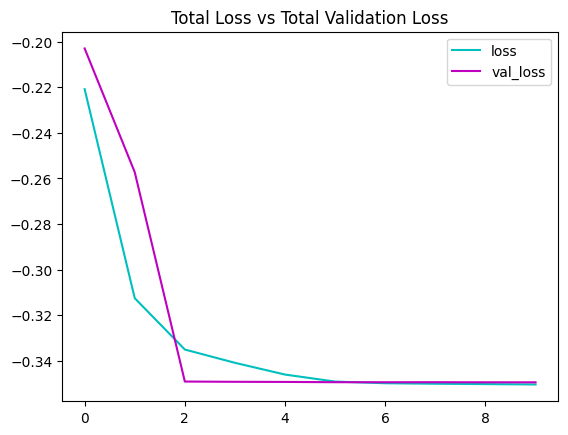

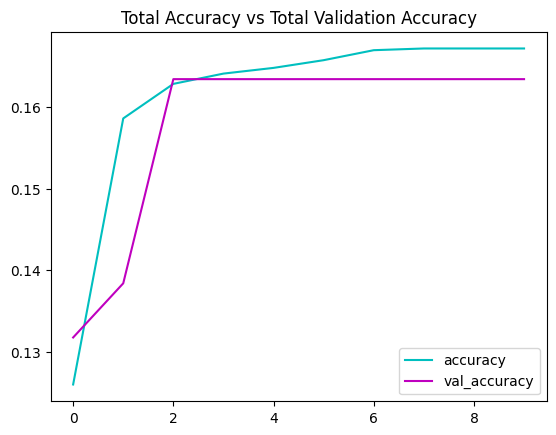

In [278]:
# Visualize the training and validation loss metrices.
plot_metric(hist, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Visualize the training and validation accuracy metrices.
plot_metric(hist, 'accuracy', 'val_accuracy',
            'Total Accuracy vs Total Validation Accuracy')

In [279]:
import datetime as dt
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(
    current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'ASL_Date_Time_{current_date_time_string}___Loss_{test_loss}___Accuracy_{test_accuracy}.h5'
model_file_path = main_path + 'model/'
os.makedirs(model_file_path, exist_ok=True)

# Save your Model.
model.save(model_file_path + f'{model_file_name}')

In [280]:
Y_pred = model.predict(X_test)
print(Y_pred)

90/90 [==============================] - 2s 18ms/step
[[-0.58119154  1.3774499   1.5022426  ... 13.264603    1.1105725
  -1.7474707 ]
 [-0.61423856  1.3225509   1.5428597  ... 13.200423    1.0785857
  -1.7053293 ]
 [-0.61781263  1.3221841   1.5454874  ... 13.200972    1.0782936
  -1.7038594 ]
 ...
 [-0.56080544  1.3382847   1.5424645  ... 13.429582    1.0668103
  -1.7372981 ]
 [-0.6258306   1.3209226   1.5544529  ... 13.21283     1.0760949
  -1.700106  ]
 [-0.5822887   1.3671535   1.508601   ... 13.275025    1.1021681
  -1.7424487 ]]


In [281]:
yhat = model.predict(X_test)


def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None


ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

y = []
for v in ytrue:
    y.append(get_key_by_value(labels_dict, v))
print(y)


ypred = []
for v in yhat:
    ypred.append(get_key_by_value(labels_dict, v))
print(ypred)

90/90 [==============================] - 2s 16ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png',
                          show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

### Saving Model


In [ ]:
name = 'asl_model'
model_filepath = 'model/'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}')
model.save(model_filepath + f'/{name}.h5')

converter = tf.lite.TFLiteConverter.from_saved_model(
    model_filepath + f'/{name}')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open(model_filepath + f'/{name}.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
name = 'asl_model'
model_filepath = main_path + 'model/'
model.load_weights(model_filepath + f'/{name}.h5')

# Keypoints using MP Holistic


In [ ]:
def mediapipe_detection(image, model):
    # COLOR CONVERSION BGR 2 RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,
                              mp_holistic.FACEMESH_TESSELATION)  # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks,
                              mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                              mp_holistic.HAND_CONNECTIONS)  # Draw right hand connections

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(
                                  color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(
                                  color=(80, 256, 121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(80, 44, 121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(121, 44, 250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(
                                  color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(
                                  color=(245, 66, 230), thickness=2, circle_radius=2)
                              )

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()